In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection as modsel

plt.style.use('ggplot')

In [2]:
filename= 'PS_20174392719_1491204439457_log.csv'
DT = pd.read_csv(filename)

### Data Inspection

In [3]:
DT.info()
DT.head(10)

print('')
print('Dataset Contains Null Values: %r' % DT.isnull().values.any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB

Dataset Contains Null Values: False


### Raw Data EDA & Data Cleaning

**Data Variable:** Step
- It is unlikely that the ***step*** field is of any significant value. It appears to be a monotonically increasing numerical value for the vast majority of the dataset, which is typical of numeric ID of the transaction or the amount of time since the first data entry. 

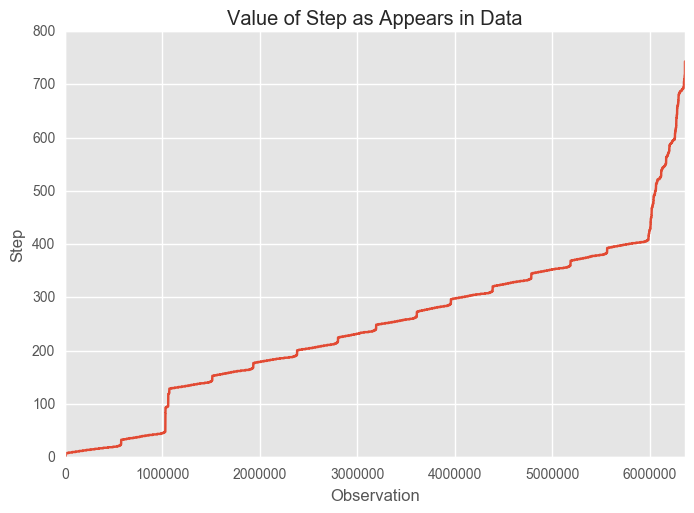

count    6.362620e+06
mean     2.433972e+02
std      1.423320e+02
min      1.000000e+00
25%      1.560000e+02
50%      2.390000e+02
75%      3.350000e+02
max      7.430000e+02
Name: step, dtype: float64

In [4]:
DT['step'].plot()
plt.xlabel('Observation')
plt.ylabel('Step')
plt.title('Value of Step as Appears in Data')
plt.show()

DT['step'].describe()

**Data Variables:** Origin Account (nameOrig) and Destination Account (nameDest)
- The unique numbers of ***nameOrig*** and ***nameDest*** are less than the total number recorded transactions. This indicates that a subset of both account types have multiple recorded transactions within the dataset. 

- It should be noted that it is possible that there are accounts that are not shared between the 2 account types. This pattern would likely be characteristic of a real dataset.

In [5]:
print('Total Documented Transactions: %d' % len(DT['nameOrig']))
print('Number of Unique Origin Accounts: %d' % len(DT['nameOrig'].unique()))
print('Number of Unique Destination Accounts: %d' % len(DT['nameDest'].unique()))

Total Documented Transactions: 6362620
Number of Unique Origin Accounts: 6353307
Number of Unique Destination Accounts: 2722362


**Data Variables:** type , amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest
- There are prominent interactions between these fields because of the natures of the transactions. 
- Once ***type*** is specified, the changes in the balances of the accounts are uniquely determined by the amount of money that is ***paid***, ***transferred***, ***cashed out***, ***cashed in***, or charged to ***debit***.

- The only information the balance fields provide that is unique to each transaction is the initial money level in the accounts before the transaction occurs. Based on this, it may be useful to eliminate the '*newbalance*' fields.

In [6]:
print(DT['type'].unique())

['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']


**Distribution of Fraud Type**
- The only types of fraud that are present in this synthetic data set are illegal money transfers and cash outs.

- It is possible that each illegal **cash_out** transaction is associated with a unique **transfer** because the total number of transfers is very close to the total number of cash outs. ***If this is correct, it would not be helpful to  use the number of transfers to a single account as a predictor of fraud***.

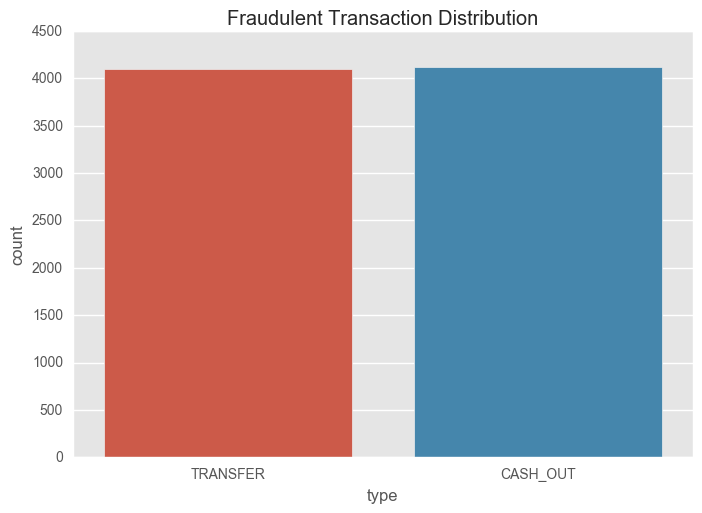

count         8213
unique           2
top       CASH_OUT
freq          4116
Name: type, dtype: object



In [7]:
sns.countplot(data=DT[(DT.isFraud==1)],x='type')
plt.title('Fraudulent Transaction Distribution')
plt.show()
DT[(DT.isFraud==1)].describe()
print(DT[(DT.isFraud==1)]['type'].describe())
print('')

**Frequency of Fraud Occurrence**
- The frequency of fraudulent TRANFER/CASH_OUT transactions to legitimate transactions is extremely small. If the full data is used to create a model, the fraudulent transactions will be effectively treated as noise instead of distinct classes.
- ***Resampling*** (fraud data) and/or ***undersampling*** (legitimate data) has to be used to create training data sets with better balances of fraudulent and legitimate transactions.

In [8]:
print('Total Number of Transfers and Cash_Outs: ' + 
          str(DT[(DT['type']=='TRANSFER') | (DT['type']=='CASH_OUT')].shape[0]) )

fraud_to_legit_ratio = 8213/2770409
print('Proportion of Fraudulent to Legitimate Transfer/Cash_out Transactions: ' + str(fraud_to_legit_ratio))

Total Number of Transfers and Cash_Outs: 2770409
Proportion of Fraudulent to Legitimate Transfer/Cash_out Transactions: 0.002964544224336551


### REDUCED DATASET 
 - ***Identifying and characterizing fraudulent money transfers will be the focus of this study***. 
 - The reduced data is built to include only **TRANSFER** transactions.

In [27]:
#DT_reduced=DT[(DT['type']=='TRANSFER') | (DT['type']=='CASH_OUT')]
DT_reduced=DT[(DT['type']=='TRANSFER')]

### Reduced Data EDA

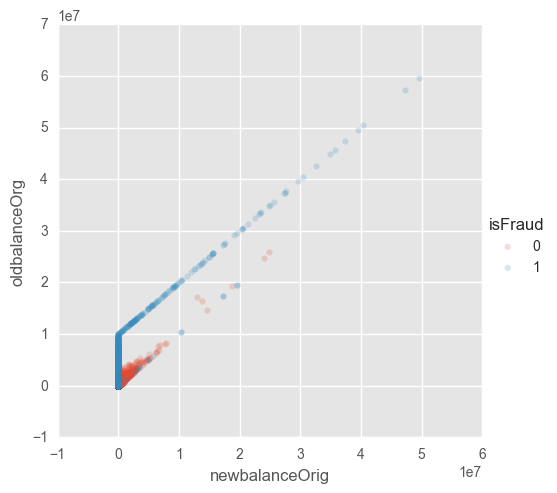

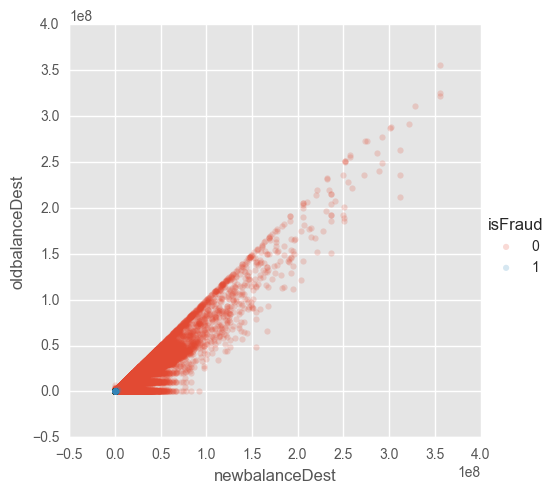

In [35]:
sns.lmplot(data = DT_reduced,x='newbalanceOrig',y = 'oldbalanceOrg',hue = 'isFraud',fit_reg=False,scatter_kws={'alpha': 0.2})
plt.show()

sns.lmplot(data = DT_reduced,x='newbalanceDest',y = 'oldbalanceDest',hue = 'isFraud',fit_reg=False,scatter_kws={'alpha': 0.2})
plt.show()


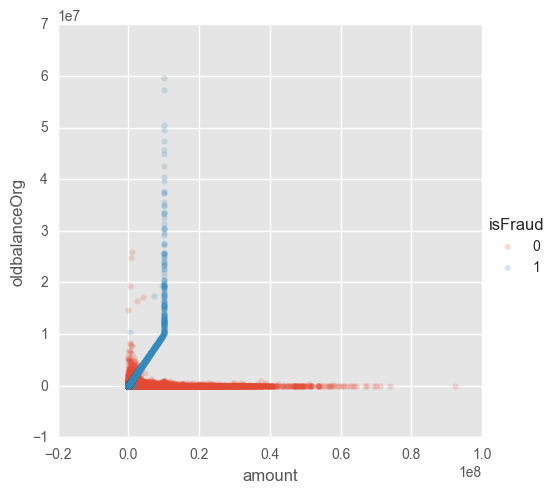

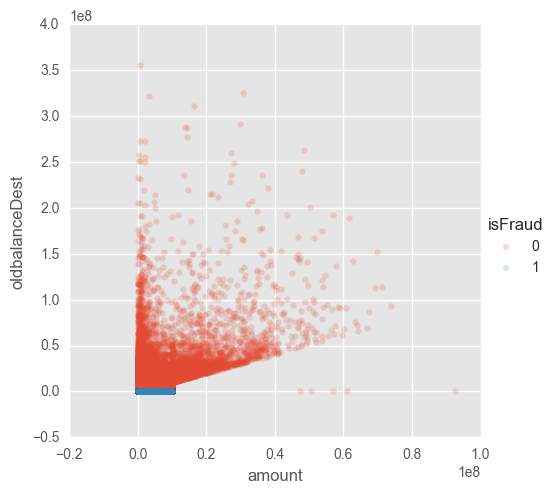

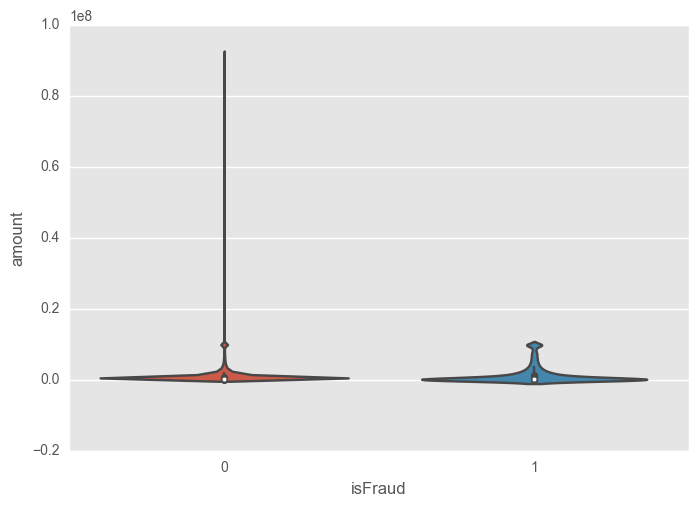

In [37]:
sns.lmplot(data = DT_reduced,x='amount',y = 'oldbalanceOrg',hue = 'isFraud',fit_reg=False,scatter_kws={'alpha': 0.2})
plt.show()

sns.lmplot(data = DT_reduced,x='amount',y = 'oldbalanceDest',hue = 'isFraud',fit_reg=False,scatter_kws={'alpha': 0.2})
plt.show()

sns.violinplot(data = DT_reduced,y='amount',x = 'isFraud')
plt.show()

#### Data Partitioning
1. Create an 80/20 data split accounting for differences in the sample sizes.
    + For the purposes of simplicity the destination account for **TRANSFER** data and origination account for **CASH_OUT** data will not be paired during the data splitting.
    + This approach can only create detection algorithms that may only be able to detect fraud immediately after it occurs but will be unable to make use of origination-destination account pairing.
2. Create 10 training Sets with different fraud-to-legitimate proportions with the constraint that within eath data set, the fraud accounts for more than 20% but less than 80% of the observations (***These constraints are subjective***). For this analysis, resampling will be done without replacement.



In [25]:
X_train, X_test,y_train,y_test = modsel.train_test_split(DT_reduced.drop('isFraud',axis=1),DT_reduced['isFraud'],test_size=0.20,random_state=1234)

y_train = y_train==1
y_test = y_test==1

In [26]:
y_train.describe()

count     426327
unique         2
top        False
freq      423075
Name: isFraud, dtype: object

In [27]:
#Create Fraud & Legitimate Transaction Index Arrays
fraud_indx = np.where(y_train==True)[0]
legit_indx = np.where(y_train==False)[0]

#Specify Train Set Size
size = 3000

#Specify proportions of fraud for each training set
fraud_prop=[]
for i in range(10):
    fraud_prop.append( (20+i*6)*.01 )

#Create fraud & legit index arrays for each training set
fraud_samp_indx=[]
legit_samp_indx=[]
for i in fraud_prop:
    fraud_samp_indx.append(np.random.choice(fraud_indx,size = int(i*size),replace=False).tolist())
    legit_samp_indx.append(np.random.choice(fraud_indx,size = int((1-i)*size),replace=False).tolist())

In [28]:
DT_reduced.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')